# Titanic: Machine Learning from Disaster

From the Kaggle competition [description](https://www.kaggle.com/c/titanic/data) ...

<blockquote>In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.</blockquote>

#### TODO
* Continue exploring evaluarion, dumping out CV stats and results from XGB  
* Then experiment with params to try and boost scores

In [48]:
import math
import pandas as pd
import numpy as np

# Do not use normal form (scietific notation) when printing numbers, exponents can make it harder to compare values
pd.set_option('float_format', '{:f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
#%pylab inline
# pylab.rcParams['figure.figsize'] = (15, 6)

from scipy.stats import uniform, randint

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
'numpy: {}, pandas: {}, sklearn: {}'.format(np.__version__, pd.__version__, sklearn.__version__)

'numpy: 1.15.1, pandas: 0.23.4, sklearn: 0.19.1'

## Import

In [3]:
def read_titanic_data(filename):
    return pd.read_csv("../datasets/kaggle/titanic/" + filename, index_col="PassengerId")

In [4]:
train_data = read_titanic_data("train.csv")
test_data = read_titanic_data("test.csv")

In [5]:
X_train = train_data.drop(["Survived"], axis=1)
y_train = train_data["Survived"].copy()
X_test = test_data.copy()

## Explore

In [79]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.283300,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,NaN,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [8]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


View the distribution of categorical data

In [9]:
train_data.describe(include=np.object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Troupiansky, Mr. Moses Aaron",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [10]:
train_data.shape

(891, 11)

View histograms of all numeric features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A936D49E10>,
      dtype=object)

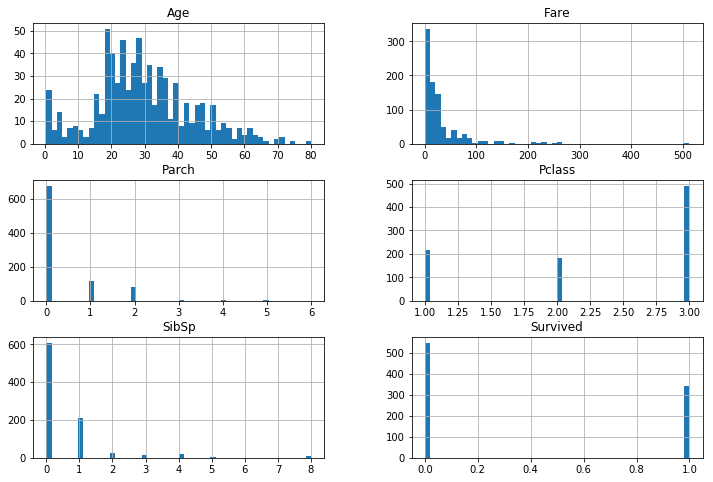

In [11]:
train_data.hist(bins=50, figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A937109940>,
      dtype=object)

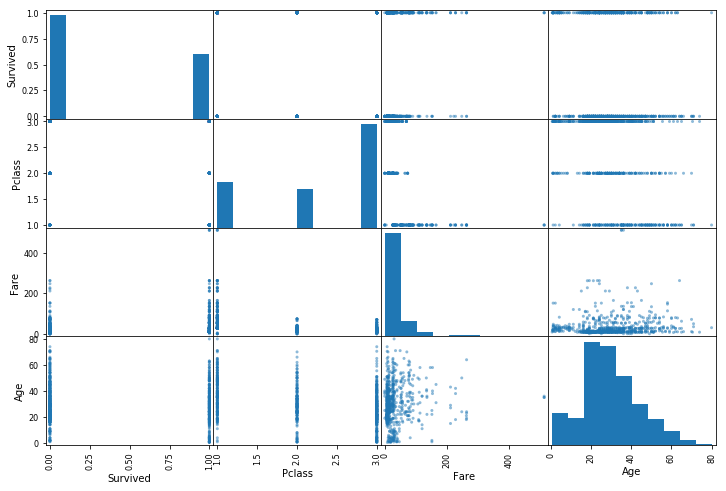

In [12]:
from pandas.plotting import scatter_matrix

scatter_features = ["Survived", "Pclass", "Fare", "Age"]
scatter_matrix(train_data[scatter_features], figsize=(12, 8))

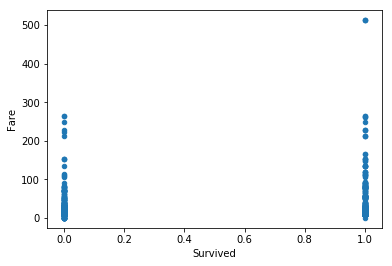

In [13]:
train_data.plot(kind="scatter", x="Survived", y="Fare")

In [14]:
class_counts = train_data["Pclass"].value_counts()
class_counts

3    491
1    216
2    184
Name: Pclass, dtype: int64

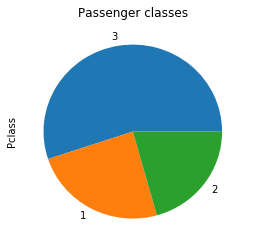

In [15]:
class_counts.plot(kind="pie", title="Passenger classes", figsize=(4, 4))

Investigate correlations

In [16]:
corr_matrix = train_data.corr()

In [17]:
corr_matrix["Survived"]

Survived    1.000000
Pclass     -0.338481
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

In [18]:
corr_survived = corr_matrix["Survived"].drop("Survived")

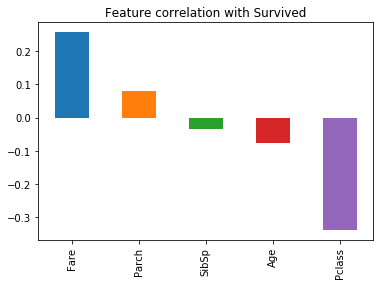

In [19]:
corr_survived.sort_values(ascending=False).plot(kind='bar', title='Feature correlation with Survived')

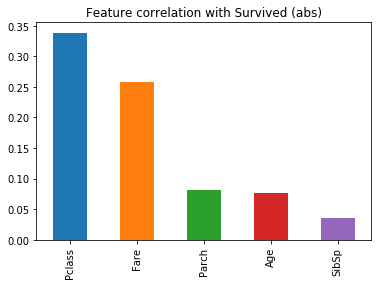

In [20]:
corr_survived.abs().sort_values(ascending=False).plot(kind='bar', title='Feature correlation with Survived (abs)')

View the correlation between passenger class and survival

In [21]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


## Feature engineering

Extract a list of `Title`s, used to map down to smaller set of category values

In [6]:
pd.concat(
    [test_data["Name"].str.extract(' ([A-Za-z]+)\.', expand=False),
    train_data["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)]
).value_counts()


Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Ms            2
Mlle          2
Don           1
Dona          1
Countess      1
Jonkheer      1
Sir           1
Lady          1
Capt          1
Mme           1
Name: Name, dtype: int64

#### Process _Embarked_

Find the most common embarcation point

In [7]:
train_data["Embarked"].value_counts().head(1)

S    644
Name: Embarked, dtype: int64

## Using a pipeline

Build a pipeline to apply the following transformations

1. Extract Title from _Name_
2. Calculate FamilySize from _SibSp_ and _Parch_
3. Replace _Embarked_ codes with city names
4. One-hot encode _Embarked_, _Sex_ and _Title_
5. Drop _Name_, _Age_, _Cabin_ and _Ticket_ features
6. Fill _Fare_ with mean (there's a NaN Fare in the test set)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Transformer that selects a set of columns
    """
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [10]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    """Transformer that drops the given columns
    """
    
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.drop(self.columns, axis=1)

In [11]:
class ExtractFamilySizeTransformer(BaseEstimator, TransformerMixin):
    """Transformer that extracts a FamilySize column from SibSp and Parch
    """
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.assign(FamilySize = lambda _: _.SibSp + _.Parch + 1)

In [12]:
class ExtractTitleTransformer(BaseEstimator, TransformerMixin):
    """Transformer that extracts a Title column from Name
    """
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.assign(Title = lambda _: _.Name.str.extract(' ([A-Za-z]+)\.', expand=False))

In [13]:
class FillnaTransformer(BaseEstimator, TransformerMixin):
    """Transformer that fills in NA values
    """
    
    def __init__(self, value):
        self.value=value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(self.value)

In [14]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    """Transformer that one-hot encodes the given columns
    """
    
    def __init__(self, columns=None, drop_first=False):
        self.columns = columns
        self.drop_first=drop_first
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X, columns=self.columns, drop_first=self.drop_first)

In [15]:
class ImputerTransformer(BaseEstimator, TransformerMixin):
    """Transformer that imputes missing values
    """    
    
    def __init__(self, strategy="mean"):
        self.strategy=strategy
    def fit(self, X, y=None):
        self.imputer = Imputer(strategy=self.strategy).fit(X)
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.DataFrame(self.imputer.transform(X), index=X.index, columns=X.columns)

In [16]:
class ReplaceValueTransformer(BaseEstimator, TransformerMixin):
    """Transformer that replaces values
    """
    
    def __init__(self, to_replace, value):
        self.to_replace = to_replace
        self.value = value
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X[self.to_replace].replace(self.value, inplace=True)
        return X

In [17]:
class ScalerTransformer(BaseEstimator, TransformerMixin):
    """Transformer that performs standard scaling
    
    Same behaviour as `StandardScaler` but outputs a DataFrame
    """    
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.scaler = StandardScaler().fit(X)
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.DataFrame(self.scaler.transform(X), index=X.index, columns=X.columns)

In [18]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """Transformer to select the most important attributes
    
    For performance reasons feature importances should be calculated outside the estimator
    """
        
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
        
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[:, self.feature_indices_]

In [19]:
titles = {
    "Mr": "Mr",
    "Miss" : "Miss",
    "Mrs" : "Mrs",
    "Master" : "Master",
    "Dr": "Mr",
    "Rev": "Mr",
    "Mlle": "Miss",
    "Major": "Mr",
    "Col": "Mr",
    "Ms": "Mrs",
    "Sir" : "Mr",    
    "Jonkheer": "Mr",
    "Mme": "Mrs",
    "Don": "Mr",
    "Dona": "Mrs",
    "Countess":"Mrs",
    "Lady" : "Mrs",
    "Capt": "Mr"    
}

cities = {
    "C": "Cherbourg", 
    "Q": "Queenstown", 
    "S": "Southampton"
}

sex = {
    "male": 0,
    "female": 1
}

In [20]:
transformation_pipeline = Pipeline([
    ("extract_title", ExtractTitleTransformer()),
    ("replace_title", ReplaceValueTransformer("Title", titles)),
    ("extract_family_size", ExtractFamilySizeTransformer()),
    ("fill_embarked", FillnaTransformer({"Embarked": "S"})), # fill with most frequent city
    ("replace_embarked", ReplaceValueTransformer("Embarked", cities)),
    ("get_dummies", GetDummiesTransformer(["Embarked", "Sex", "Title"])),
    ("drop_columns", DropColumnsTransformer(["Name", "Cabin", "Ticket"])),
    ("impute_values", ImputerTransformer()),
    ("std_scaler", ScalerTransformer())
])

In [21]:
X_train_transformed = transformation_pipeline.fit_transform(X_train.copy())

In [22]:
X_train_transformed.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs
PassengerId,,,,,,,,,,,,,,,
1,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.059160,-0.482043,-0.307562,0.615838,-0.737695,0.737695,-0.216803,-0.510152,0.810021,-0.411450
2,-1.566107,0.638789,0.432793,-0.473674,0.786845,0.059160,2.074505,-0.307562,-1.623803,1.355574,-1.355574,-0.216803,-0.510152,-1.234536,2.430427
3,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,-0.560975,-0.482043,-0.307562,0.615838,1.355574,-1.355574,-0.216803,1.960202,-1.234536,-0.411450
4,-1.566107,0.407926,0.432793,-0.473674,0.420730,0.059160,-0.482043,-0.307562,0.615838,1.355574,-1.355574,-0.216803,-0.510152,-1.234536,2.430427
5,0.827377,0.407926,-0.474545,-0.473674,-0.486337,-0.560975,-0.482043,-0.307562,0.615838,-0.737695,0.737695,-0.216803,-0.510152,0.810021,-0.411450


## Train a model

In [23]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [24]:
def view_best_of_grid(grid: GridSearchCV):
    print("best score:", grid.best_score_)
    print("best params:", grid.best_params_)
    print("best estimator:", grid.best_estimator_)

In [25]:
def show_null_samples(frame):
    print(frame[frame.isnull().any(axis=1)])

### Train LinearSVC

In [45]:
from sklearn.svm import LinearSVC

In [46]:
clf_svc = LinearSVC(penalty="l2", dual=False, tol=1e-4)

pipeline_svc = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_linear', clf_svc)
])

pipeline_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [47]:
y_hat_svc = pipeline_svc.predict(X_test)

### Train DecisionTreeClassifier

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=42)

pipeline_tree = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_linear', clf_tree)
])

pipeline_tree.fit(X_train, y_train)                           

Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [49]:
y_hat_tree = pipeline_tree.predict(X_test)

In [52]:
pipeline_tree.score(X_train, y_train)

0.9820426487093153

### Train a random forrest

In [62]:
from sklearn.ensemble import RandomForestClassifier

clf_forrest = RandomForestClassifier(random_state=0, n_jobs=4)

In [63]:
pipeline_forrest = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_forrest', clf_forrest)
])

forrest_param_grid = [{ 
    "clf_forrest__bootstrap": [True, False],
    "clf_forrest__criterion": ["gini", "entropy"],
    "clf_forrest__n_estimators": [30, 100, 300],
    "clf_forrest__max_depth": [2, 4, 8],
    "clf_forrest__max_features": [0.8, 1.0],
    "clf_forrest__max_leaf_nodes": [4, 8, 16]
}]

search_forrest = GridSearchCV(pipeline_forrest, forrest_param_grid)

search_forrest.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...estimators=10, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf_forrest__bootstrap': [True, False], 'clf_forrest__criterion': ['gini', 'entropy'], 'clf_forrest__n_estimators': [30, 100, 300], 'clf_forrest__max_depth': [2, 4, 8], 'clf_forrest__max_features': [0.8, 1.0], 'clf_forrest__max_leaf_nodes': [4, 8, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [64]:
view_best_of_grid(search_forrest)

best score: 0.8462401795735129
best params: {'clf_forrest__bootstrap': False, 'clf_forrest__criterion': 'gini', 'clf_forrest__max_depth': 8, 'clf_forrest__max_features': 0.8, 'clf_forrest__max_leaf_nodes': 16, 'clf_forrest__n_estimators': 100}
best estimator: Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...stimators=100, n_jobs=4,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])


In [66]:
y_hat_forrest = search_forrest.predict(X_test)

### Train a gradient boosted classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
gb_params = [{ 
    "prepare_data__get_dummies__drop_first": [True, False],
    "gb_clf__learning_rate": [0.4, 0.5, 0.6, 0.8, 1.0],
    "gb_clf__n_estimators": [10, 30, 100, 150],
    "gb_clf__max_depth": [2, 3, 4],
    "gb_clf__max_features": [0.5, 0.6, 0.8, 1.0]
}]

In [31]:
gb_clf_pipeline = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('gb_clf', GradientBoostingClassifier(random_state=42))
])

In [32]:
gb_clf = GridSearchCV(gb_clf_pipeline, gb_params, cv=3, verbose=1)

These are all the hyperparameters that can potentially be set

In [33]:
list(gb_clf_pipeline.get_params().keys())

['memory',
 'steps',
 'prepare_data',
 'gb_clf',
 'prepare_data__memory',
 'prepare_data__steps',
 'prepare_data__extract_title',
 'prepare_data__replace_title',
 'prepare_data__extract_family_size',
 'prepare_data__fill_embarked',
 'prepare_data__replace_embarked',
 'prepare_data__get_dummies',
 'prepare_data__drop_columns',
 'prepare_data__impute_values',
 'prepare_data__replace_title__to_replace',
 'prepare_data__replace_title__value',
 'prepare_data__fill_embarked__value',
 'prepare_data__replace_embarked__to_replace',
 'prepare_data__replace_embarked__value',
 'prepare_data__get_dummies__columns',
 'prepare_data__get_dummies__drop_first',
 'prepare_data__drop_columns__columns',
 'prepare_data__impute_values__strategy',
 'gb_clf__criterion',
 'gb_clf__init',
 'gb_clf__learning_rate',
 'gb_clf__loss',
 'gb_clf__max_depth',
 'gb_clf__max_features',
 'gb_clf__max_leaf_nodes',
 'gb_clf__min_impurity_decrease',
 'gb_clf__min_impurity_split',
 'gb_clf__min_samples_leaf',
 'gb_clf__min_sa

In [34]:
gb_clf.fit(X_train.copy(), y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'prepare_data__get_dummies__drop_first': [True, False], 'gb_clf__learning_rate': [0.4, 0.5, 0.6, 0.8, 1.0], 'gb_clf__n_estimators': [10, 30, 100, 150], 'gb_clf__max_depth': [2, 3, 4], 'gb_clf__max_features': [0.5, 0.6, 0.8, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [35]:
view_best_of_grid(gb_clf)

best score: 0.8383838383838383
best params: {'gb_clf__learning_rate': 0.8, 'gb_clf__max_depth': 2, 'gb_clf__max_features': 0.5, 'gb_clf__n_estimators': 30, 'prepare_data__get_dummies__drop_first': True}
best estimator: Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('extract_title', ExtractTitleTransformer()), ('replace_title', ReplaceValueTransformer(to_replace='Title',
            value={'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Mr', 'Rev': 'Mr', 'Mlle': 'Miss', 'Major': 'Mr...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))])


In [36]:
gb_clf_score = gb_clf.score(X_train, y_train)
"best gradient boosting classifier score: {}".format(gb_clf_score)

'best gradient boosting classifier score: 0.8855218855218855'

In [37]:
y_hat_gb = gb_clf.predict(X_test.copy()) 

### Train an XGBoost classifier

In [140]:
# Ignore numpy deprecation warning, see https://github.com/scikit-learn/scikit-learn/issues/10449
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import xgboost as xgb

clf_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

pipeline_xgb = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_xgb', clf_xgb)
])

params_xgb = {
    "clf_xgb__colsample_bytree": uniform(0.7, 0.3),
    "clf_xgb__gamma": uniform(0, 0.5),
    "clf_xgb__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "clf_xgb__max_depth": randint(2, 6), # default 3
    "clf_xgb__n_estimators": randint(100, 150), # default 100
    "clf_xgb__subsample": uniform(0.6, 0.4)
}

search_xgb = RandomizedSearchCV(pipeline_xgb, param_distributions=params_xgb, random_state=42, n_iter=10, cv=3, verbose=1, n_jobs=1, return_train_score=True)

best_model_xgb = search_xgb.fit(X_train, y_train)

y_hat_xgb = best_model_xgb.predict(X_test)

# warnings.filterwarnings(action='default', category=DeprecationWarning)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.8s finished


#### Examining the performance of XGBoost  

In [141]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# `roc_curve` requires a y_test, so we'll split the test data as we don't have a y_test for the Kaggle data
X_train_xgb_eval, X_test_xgb_eval, y_train_xgb_eval, y_test_xgb_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

clf_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

pipeline_xgb = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('clf_xgb', clf_xgb)
])

pipeline_xgb.fit(X_train_xgb_eval, y_train_xgb_eval)

y_hat_vals_xgb = pipeline_xgb.predict(X_test_xgb_eval)
y_hat_prob_xgb = pipeline_xgb.predict_proba(X_test_xgb_eval)

In [168]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def print_scores(y_true, y_pred):   
    accuracy = accuracy_score(y_true, y_pred)

    # the fraction of prediced positive events that are actually positive
    precision = precision_score(y_true, y_pred)

    # the fraction of positive events that were predicted correctly, a.k.a. sensitivity
    recall = recall_score(y_true, y_pred)

    # the harmonic mean of recall and precision, higher is better
    f1 = f1_score(y_true, y_pred)
 
    print("accuracy: {:.3f}\nprecision: {:.3f}\nrecall: {:.3f}\nf1: {:.3f}".format(accuracy, precision, recall, f1))

In [169]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, "b-", label="XGBoost AUC: {0:.3f}".format(roc_auc))
    plt.plot([0, 0, 1, 1], [0, 1, 1, 1], "g-", label="Perfect")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate (1 - Specificity)", size=16)
    plt.ylabel("True Positive Rate (Sensitivity)", size=16)
    plt.title("ROC curve", size=20)
    plt.legend(fontsize=14);

In [170]:
import itertools
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test_xgb_eval.values, y_hat_vals_xgb)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')  

In [171]:
print_scores(y_test_xgb_eval.values, y_hat_vals_xgb)

accuracy: 0.816
precision: 0.806
recall: 0.730
f1: 0.766


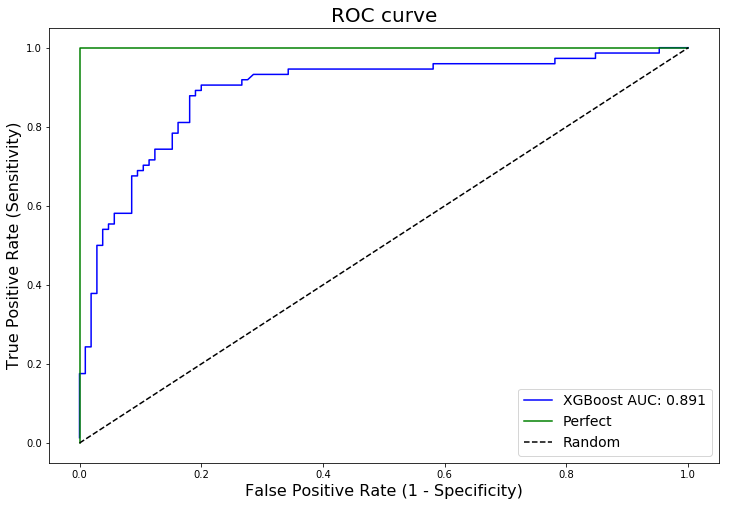

In [172]:
fpr, tpr, thresholds = roc_curve(y_test_xgb_eval.values, y_hat_prob_xgb[:, 1])
roc_auc = roc_auc_score(y_test_xgb_eval.values, y_hat_prob_xgb[:, 1])

plot_roc_curve(fpr, tpr, roc_auc)

Confusion matrix, without normalization
[[92 13]
 [20 54]]


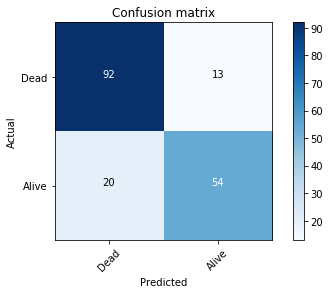

In [173]:
plot_confusion_matrix(matrix, classes=["Dead", "Alive"], normalize=False)  

## Evaluate

Plot the feature coefficients

In [267]:
coefficients = pd.Series(clf_svc.coef_[0], X_train.columns).sort_values()

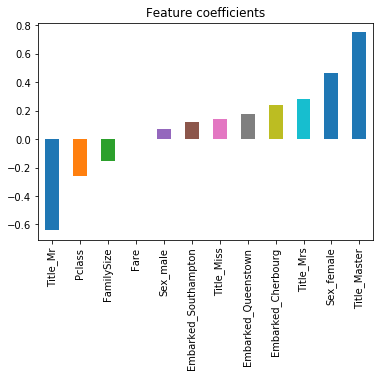

In [258]:
coefficients.plot(kind='bar', title='Feature coefficients')

View the R^2 on the training dataset

In [259]:
r_square_train = clf_svc.score(X_train, y_train)
r_square_train

0.8327721661054994

## Submit

Create submission

In [93]:
submission = pd.DataFrame({
  "PassengerId": X_test.index,
  "Survived": y_hat_xgb
})

In [94]:
submission.to_csv("../datasets/kaggle/titanic/submission.csv", index=False)

Submit using the Kaggle CLI

In [95]:
!kaggle competitions submit -c titanic -f ../datasets/kaggle/titanic/submission.csv -m "pipeline xgb"`

Successfully submitted to Titanic: Machine Learning from Disaster


Jump to the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) to see the score and ranking

# Summary

| Model              | Notes                            | Model score | Kaggle score   | Leaderboard |
| ------------------ | -------------------------------- | ----------- | -------------- | ----------- |
| `LinearSVC`        | Bare bones feature engineering   |     0.79910 |        0.77033 |       6,981 |
| `LinearSVC`        | Added Title and 1-hot encoded it |     0.82940 |        0.78947 |       3,587 |
| `LinearSVC`        | Added FamilySize feature         |     0.83277 |        0.78947 |       3,507 |
| `DecisionTree`     | Using a decision tree model      |             |        0.79425 |       2,493 |
| `RandomForrest`    | With grid search                 |     0.83501 |        0.79904 |       1,764 |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |
|                    |                                  |             |                |             |



Show sco